In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [5]:
test_batch_size = 1000
batch_size = 64
epochs = 2
lr = 0.1
gamma = 0.7
seed = 1
no_cuda = False
log_interval = 1000
save_model = True
use_cuda = True

In [6]:
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [8]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [9]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.327989

Test set: Average loss: 0.0873, Accuracy: 9733/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.068950

Test set: Average loss: 0.0559, Accuracy: 9814/10000 (98%)



In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [11]:
print(example_targets.shape)
print(example_data.shape)

torch.Size([1000])
torch.Size([1000, 1, 28, 28])


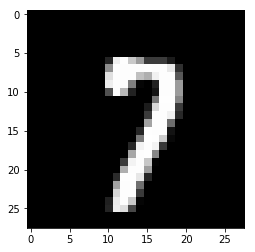

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')

In [13]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [14]:
x = example_data[0,:,:,:].unsqueeze_(0).requires_grad_(True)
print(x.shape)

y = example_targets[0]

torch.Size([1, 1, 28, 28])


In [15]:
y_hat = model(x.cuda() if torch.cuda.is_available() else x)
y_hat.shape

torch.Size([1, 10])

In [16]:
y_hat.argmax()

tensor(7, device='cuda:0')

### step by step derivatives

In [17]:
# df/dx
ddx, = torch.autograd.grad(model(x.cuda() if torch.cuda.is_available() else x).mean(), x, create_graph=True)

In [18]:
ddx.shape

torch.Size([1, 1, 28, 28])

In [19]:
ddx

tensor([[[[ 1.2400e-03, -3.8826e-04, -7.6100e-04, -1.9442e-03, -6.0563e-03,
           -4.1895e-03, -8.3039e-03, -3.9765e-03, -3.1987e-03,  1.5219e-03,
            9.1926e-04,  4.8199e-03,  4.5932e-03,  4.2406e-03,  2.6201e-03,
            6.0481e-04,  4.5298e-04,  8.1611e-04, -4.0886e-04, -2.5064e-03,
           -2.1416e-03, -8.2743e-04, -6.5567e-04, -8.5979e-04, -1.3410e-03,
           -2.2002e-04, -5.0362e-05,  0.0000e+00],
          [ 6.9169e-04, -2.2784e-03, -6.2987e-03,  1.5007e-03, -4.4067e-03,
           -2.0033e-03, -2.0041e-03, -1.5064e-03,  1.2349e-03, -5.0560e-03,
            2.5222e-03, -3.2680e-04,  5.6045e-03, -1.5649e-03,  5.1843e-04,
           -4.4274e-04,  4.7826e-03,  3.8842e-03,  2.3828e-03,  3.6087e-03,
            5.9034e-03, -6.8823e-04, -4.5311e-03, -1.0175e-03,  4.5790e-04,
            1.5634e-04,  1.4634e-03,  0.0000e+00],
          [-7.2952e-04,  3.9195e-03, -5.8709e-03,  8.9449e-04, -8.2499e-03,
            3.6377e-03,  2.2995e-03, -1.6895e-03, -1.2900e-02,

In [20]:
ddx.mean().backward()
# x.grad = d^2 f(x)/dx^2

In [21]:
#d^2 f(x)/dx^2
x.grad

tensor([[[[-5.7239e-09,  6.7585e-09,  5.7199e-09,  2.7605e-08,  2.8381e-08,
            1.4564e-08,  6.5678e-08,  2.1743e-08, -2.2060e-09, -5.1864e-08,
           -5.4644e-08, -9.0430e-08, -1.2326e-07, -1.0797e-07, -5.6546e-08,
           -6.6697e-08, -8.7395e-09, -1.5370e-08,  3.7518e-09,  6.8961e-09,
           -9.2153e-09, -1.7597e-08, -2.2353e-08,  5.2450e-09, -1.2332e-08,
           -1.0254e-08, -1.5994e-08,  0.0000e+00],
          [ 2.0502e-09,  2.8550e-08,  4.0453e-08, -8.1824e-08,  1.8304e-08,
           -3.4195e-08,  1.7319e-08, -5.3985e-08, -1.1213e-07, -4.9202e-08,
           -8.4463e-08, -6.4605e-08, -9.9305e-08, -2.5943e-08, -5.0645e-08,
           -9.3706e-08, -1.0497e-07, -1.0010e-07, -7.4924e-08, -1.0620e-07,
           -1.7271e-07, -7.4307e-08, -9.7478e-09, -3.5966e-08, -4.2050e-08,
           -2.6505e-08,  1.0275e-08,  0.0000e+00],
          [-7.6887e-08, -1.8364e-07, -1.5399e-07, -2.3226e-07, -2.4126e-07,
           -2.9356e-07, -2.7659e-07, -1.7667e-07, -7.8588e-08,

In [22]:
### taylor series
str("P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...")

'P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...'

In [23]:
y_hat.shape

torch.Size([1, 10])

In [24]:
# f'(x)
ddx.shape

torch.Size([1, 1, 28, 28])

In [25]:
# f''(x)
x.grad.shape

torch.Size([1, 1, 28, 28])

In [26]:
terms = ddx*x + x.grad*(x.pow(2))

In [27]:
terms.shape

torch.Size([1, 1, 28, 28])

In [28]:
class DynamicGNoise(nn.Module):
    def __init__(self, shape, std=0.05):
        super().__init__()
        self.noise = torch.zeros(shape).requires_grad_(True)
        self.std   = std
        
    def forward(self, x):
#         if not self.training: return x
        self.noise.data.normal_(0, std=self.std)
        
        print(x.size(), self.noise.size())
        return x + self.noise

In [29]:
noise = DynamicGNoise((1,1,28,28)).to(device)

In [30]:
x_new = noise(x)

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


In [31]:
x_new.shape

torch.Size([1, 1, 28, 28])

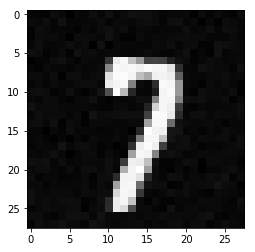

In [32]:
plt.imshow(x_new.squeeze(0).squeeze(0).detach().numpy(), cmap='gray', interpolation='none')

In [33]:
f = model(x_new.cuda() if torch.cuda.is_available() else x_new)

In [34]:
term = ddx*(x_new-x) + x.grad*((x_new-x)**2)

In [35]:
term.shape

torch.Size([1, 1, 28, 28])

In [36]:
term_ = model(term.cuda() if torch.cuda.is_available() else term)

In [37]:
new_f = f + term_

#### Verified that image around '9' can be labels by this formula

In [38]:
new_f.argmax()

tensor(7, device='cuda:0')

### conversion of the above steps in functions

In [39]:
def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      

In [40]:
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)                                                                                                                                                 

In [42]:
##Testing purpose
# def f(x):                                                                                             
#     return x * x * torch.arange(4, dtype=torch.float)                                                                                                                                         

In [43]:
# # x = torch.ones(4, requires_grad=True)                                                                 
# print(jacobian(y_hat, x.cuda() if torch.cuda.is_available() else x))                                                                              
# print(hessian(y_hat, x.cuda() if torch.cuda.is_available() else x))                                                                               

In [45]:
# first order derivative term
jacobian_ = jacobian(y_hat, x)
jacobian_

tensor([[[[[[-3.4623e-05, -3.0608e-04, -9.8174e-04,  ...,  1.6534e-03,
              7.0800e-04,  0.0000e+00],
            [ 9.1233e-04, -2.7026e-03, -9.0700e-03,  ...,  3.1274e-03,
              4.5002e-03,  0.0000e+00],
            [-3.6463e-03,  1.4521e-04, -1.2769e-02,  ..., -1.5624e-02,
             -4.4999e-03,  0.0000e+00],
            ...,
            [-1.3149e-03, -2.5545e-03, -6.6746e-03,  ..., -4.1787e-03,
             -3.4475e-03,  0.0000e+00],
            [-2.1590e-03, -7.5081e-03, -4.4928e-03,  ..., -1.7665e-04,
              1.8192e-04,  0.0000e+00],
            [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
              0.0000e+00,  0.0000e+00]]]],



         [[[[ 1.7331e-03, -6.2811e-04, -4.4870e-04,  ..., -1.9452e-03,
             -7.6963e-04,  0.0000e+00],
            [-2.6612e-04, -3.4425e-03, -9.2598e-03,  ..., -9.8516e-05,
              4.8039e-03,  0.0000e+00],
            [-5.1099e-03,  2.0904e-03, -1.2794e-02,  ..., -7.1642e-03,
             -2.95

In [54]:
jacobian_.shape

torch.Size([1, 10, 1, 1, 28, 28])

In [47]:
# second order derivative term
hessian_ = hessian(y_hat, x)
hessian_

tensor([[[[[[[[[[-8.6772e-10,  8.7699e-10,  1.1912e-09,  ...,
                 -1.0244e-09, -1.4158e-09,  0.0000e+00],
                [ 4.1285e-10,  3.8345e-09,  6.1219e-09,  ...,
                 -2.6997e-09,  4.6680e-10,  0.0000e+00],
                [-6.8246e-09, -1.8525e-08, -1.2302e-08,  ...,
                  6.3354e-09,  3.7730e-09,  0.0000e+00],
                ...,
                [-1.2642e-11, -3.5553e-09, -8.7867e-09,  ...,
                  5.3280e-09,  7.9332e-09,  0.0000e+00],
                [ 1.0330e-09,  3.8235e-09,  9.6121e-09,  ...,
                 -3.1357e-09,  1.1242e-09,  0.0000e+00],
                [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,
                  0.0000e+00,  0.0000e+00,  0.0000e+00]]]],



             [[[[ 8.7705e-10, -1.3996e-09, -1.8498e-09,  ...,
                  9.6731e-10,  1.4756e-09,  0.0000e+00],
                [-6.7941e-10, -4.8181e-09, -6.9518e-09,  ...,
                  2.1620e-09, -9.1951e-10,  0.0000e+00],
                [ 8.0

In [48]:
hessian_.shape

torch.Size([1, 10, 1, 1, 28, 28, 1, 1, 28, 28])

In [1]:
# stack jacobians and add the resultant tensor to hessian
# then we take the mean on hessian to get its dimension to [1,10]
# we then add it to y_hat
# the resultant vector will give probability distribution for noisy '9' in our case.

# WIP

In [56]:
processed_jacobian = torch.mean(jacobian_, dim=[2,3,4,5])
processed_hessian = torch.mean(hessian_, dim=list(range(2,10)))

In [59]:
print("jacobian|",processed_jacobian.shape)
print("hessian|", processed_hessian.shape)

jacobian| torch.Size([1, 10])
hessian| torch.Size([1, 10])


In [65]:
term = processed_jacobian*torch.mean((x_new-x)) + processed_hessian*torch.mean(((x_new-x)**2))/2

In [67]:
P = f + term.cuda()

In [68]:
P

tensor([[-1.1630e+01, -1.2518e+01, -7.5958e+00, -9.1055e+00, -1.4015e+01,
         -1.4933e+01, -1.6146e+01, -2.7180e-03, -1.0087e+01, -6.1923e+00]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [69]:
y_hat

tensor([[-1.1486e+01, -1.2412e+01, -7.6701e+00, -9.1575e+00, -1.3939e+01,
         -1.4900e+01, -1.6025e+01, -2.8400e-03, -1.0010e+01, -6.1177e+00]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [71]:
print("Original|", y_hat.argmax())
print("Noised|", P.argmax())

Original| tensor(7, device='cuda:0')
Noised| tensor(7, device='cuda:0')
